# Cálculo de error entre modelos y optimización de parámetros.

La idea es hacer una función que tome los parámetros del modelo y pueda calcular el error entre el modelo generado y uno de referencia dado.

e(x) = [params]

dónde params es un vector que tiene los parámetros del modelo Ross-Macdonald.

Se establece una función que permite calcular el error de los casos diarios entre dos modelos, uno de referencia y otro el modelo desarrollado.

Una vez calculado este error, se utiliza la opción minimize en busca de minimizarlo cambiando los parámetros del modelo. En el caso de SIR, betta y gamma.

De esta manera, puede plantearse un modelo con parámetros estimativos y luego encontrar los parámetros que mejor ajustan al modelo a los datos de referencia.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

# Modelo.

In [3]:
def RossMacdonald_model(x,t, params):

    # Desarmamos el vector
    Hs, Hi, Hr, Vs, Vi = x

    r_h, beta_h, beta_v= params

    # Planteamos las ecuaciones
    dHs_dt = - beta_h * Vi * Hs/Nh
    dHi_dt = beta_h * Vi * Hs/Nh - r_h * Hi
    dHr_dt = r_h * Hi
    dVs_dt = - beta_v * Vs * Hi/Nh
    dVi_dt = beta_v * Vs * Hi/Nh

    return [dHs_dt, dHi_dt, dHr_dt, dVs_dt, dVi_dt]

# Parámetros de referencia.

In [4]:
# Parameters
r_h = 0.143
beta_h = 0.20
beta_v = 0.35

# Condiciones iniciales.

In [5]:
Nh = 1    # Total human population
Nv = 1  # Total vector population

Hi_0 = 1/1e6
Hs_0 = Nh - Hi_0
Hr_0 = 0

Vi_0 = 1/1e6
Vs_0 = Nv - Vi_0

x0 = [Hs_0, Hi_0, Hr_0, Vs_0, Vi_0] # Vector inicial

# Simulación del tiempo.

In [6]:
t_start = 0.0
t_end = 250.0
num_points = 100000
time_points = np.linspace(t_start, t_end, num_points) # Genera 1000 puntos entre 0 y 100 equiespaciados.

# Parámetros a estimar.

In [16]:
# r_h = 0.143
# beta_h = 0.20
# beta_v = 0.35

Er_h = 0.2 # Tasa de recuperacion de humanos
Ebeta_h = 0.3 # Tasa de contagio mosquito a humano
Ebeta_v = 0.3 # Tasa de contagio humano a mosquito

# Función que calcula los casos diarios.

Cabe destacar que solo importará el error de la cantidad de gente que se va infectando. Para calcular esto, notemos que la ecuación del compartimento S es:

$dS/dt = Λ_h - β_h * V_i * H_s/H - μ_h * Hs$

(Realmente esa es la ecuación el modelo original. Para un modelo de un virus como el Dengue se pueden despreciar la tasa de reclutamiento y de mortalidad de los humanos. Esto se debe a que el tiempo de permanencia del virus es corto, en invierno los mosquitos mueren y por lo tanto el virus deja de circular).

Luego, podemos deducir que la componente que pertenece a los infectados es la que acompaña a β.

Entonces lo que vamos a querer calcular como error es la diferencia de ambos modelos en la ecuacion:

$β_h * V_i * H_s/H$

In [8]:
def dailyCases(params):
  r_h, beta_h, beta_v= params
  sol = odeint(RossMacdonald_model, x0, time_points,rtol=1e-6, atol=1e-12,args=(params,))

  Hs = sol[:, 0]
  Hi = sol[:, 1]
  Hr = sol[:, 2]
  Vs = sol[:, 3]
  Vi = sol[:, 4]

  return beta_h * Vi * Hs/Nh

# Precalculo de los casos diarios de referencia.

In [9]:
dailyRef = dailyCases([r_h, beta_h, beta_v])

# Función del error.

Para calcular el error se hace la norma L2 (euclideana) entre los casos diarios predecidos y los reales. Luego se normaliza con el error de los casos reales para no entrar en errores de escala.

In [10]:
def errorFun(params):

    dailyPredict = dailyCases(params)

    errRealL2 = np.linalg.norm(dailyRef)
    errL2 = np.linalg.norm(dailyPredict - dailyRef)

    return errL2/errRealL2

# Cálculo del error.

In [11]:
# Calculamos el error entre los datos reales y el modelo con los parámetros
# propuestos.
errL2 = errorFun([Er_h, Ebeta_h, Ebeta_v])
print(errL2)

0.5069706193763742


# Minimización y búsqueda de parámetros.

In [12]:
bounds = [(0,0.5), (0,0.5), (0,0.5)]
result = differential_evolution(errorFun, bounds)

# Impresión de resultados.

In [13]:
print("Minimum found at:", result.x)
print("Minimum function value:", result.fun)
# print("Optimization successful:", result.success) // No es tan representativo este valor.
#                                                   // en algunos casos la minimización es correcta y sin embargo
#                                                   // dice false.

Minimum found at: [0.143 0.2   0.35 ]
Minimum function value: 9.809138469947885e-16


# Generamos una nueva solución con los parámetros encontrados.

In [14]:
dailyGuess = dailyCases([Er_h, Ebeta_h, Ebeta_v])
dailyPred = dailyCases(result.x)

# Gráfica de los resultados y comparación de curvas.

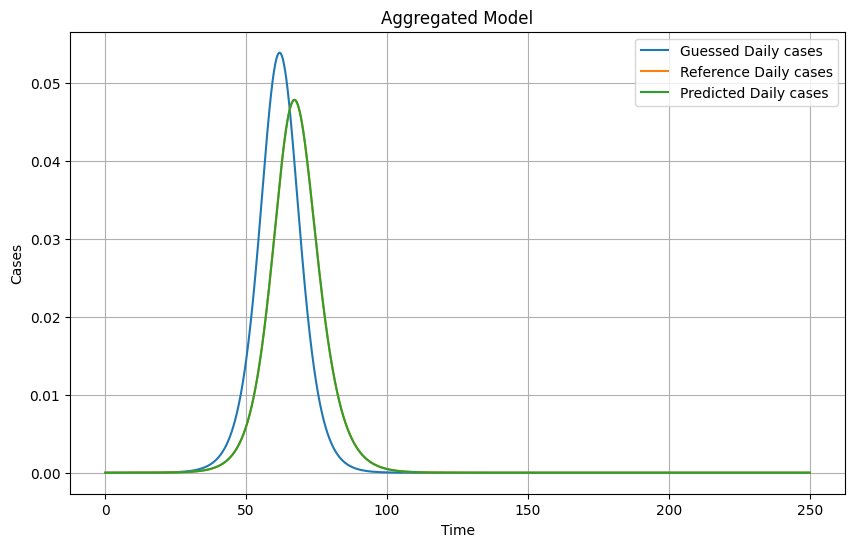

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, dailyGuess, label='Guessed Daily cases')
plt.plot(time_points, dailyRef, label='Reference Daily cases')
plt.plot(time_points, dailyPred, label='Predicted Daily cases')
plt.title('Aggregated Model')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.grid(True)
plt.legend()
plt.show()